# Portfolio

**Objective**: Demonstrate multi-currency portfolio NAV tracking with 
1. simulated NAV with cash flows, rebalancing and asset returns
2. NAV history from real life portfilio

**Key Features**:
- Multi-currency portfolio initialization
- Cash flow arrangement (contributions/withdrawals) - Well, you are saving money and spending it from time to time, this could be discretionary or rule based
- Rebalancing schedule - Imagine you invest in local currency indice with certain weights and rebalance schedule
- Return could be simulated or from real portfolios
- NAV simulation over time - from the cash flow, rebalancing schedule, returns in foreign currency assets denominated in base currency
- Portfolio constructor NAV - You are working with a given real portfolio with NAV history of foreign currency assets
- Portfolio analytics and visualization



## 1. Setup & Dependencies

In [ ]:
import os
import sys
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path so we can import src package
sys.path.insert(0, str(Path.cwd().parent))

# Import portfolio module from src package
from src import Portfolio, CashFlow, RebalanceEvent

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("Dependencies loaded")

## 2. Basic Portfolio Creation

Create a simple USD-based portfolio with exposure to EUR and GBP.

In [ ]:
# Create a basic portfolio
portfolio = Portfolio(
    base_currency='USD',
    init_date=datetime(20190, 12, 31),
    initial_nav=1_000_000,
    weights={'USD': 0.60, 'EUR': 0.30, 'GBP': 0.10},
    periodic_freq='M'  # Monthly returns
)

print(portfolio)
print(f"\nCurrencies: {portfolio.currencies}")
print(f"Initial weights: {portfolio.initial_weights}")


Portfolio initialized: USD-denominated
IMPORTANT: All currency exposures are valued in USD
  - Each currency's NAV represents USD value of those assets
  - Returns must be in USD terms (FX effects embedded)
  - Example: EUR weight of 30% = $300,000 worth of EUR assets

Portfolio(base_currency='USD', init_date='2020-01-31', initial_nav=1,000,000.00, currencies=[EUR, GBP, USD], cash_flows=0, rebalances=0)

Currencies: ['EUR', 'GBP', 'USD']
Initial weights: {'USD': 0.6, 'EUR': 0.3, 'GBP': 0.1}


## 3. Generate Random Returns

Create synthetic returns for simulation. In practice, you would use historical or forecasted returns.

In [ ]:
# Generate 5 years of monthly returns
currencies = ['EUR', 'GBP', 'USD']

returns = portfolio.generate_random_returns(
    currencies=currencies,
    n_periods=60,  # 5 * 12 periods, the period is specified in the periodic_freq attribute
    mean_returns=[0.006, 0.0055, 0.005],   
    volatilities=[0.035, 0.04, 0.03],      
    correlation_matrix=np.array([
        [1.0, 0.65, 0.7],   
        [0.65, 1.0, 0.6],   
        [0.7, 0.6, 1.0]     
    ]),
    seed=42
)

print(f"Generated {len(returns)} periods of returns")
print(f"Date range: {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")
print("\nFirst 5 periods:")
returns.head()

Generated 60 periods of returns
Date range: 2020-01-31 to 2024-12-31

First 5 periods:


,EUR,GBP,USD
2020-01-31,-0.0183,-0.0098,0.0001
2020-02-29,-0.0413,-0.0456,-0.0382
2020-03-31,-0.0285,-0.0649,-0.0325
2020-04-30,-0.0111,-0.0063,-0.0195
2020-05-31,-0.0048,0.0290,-0.0440


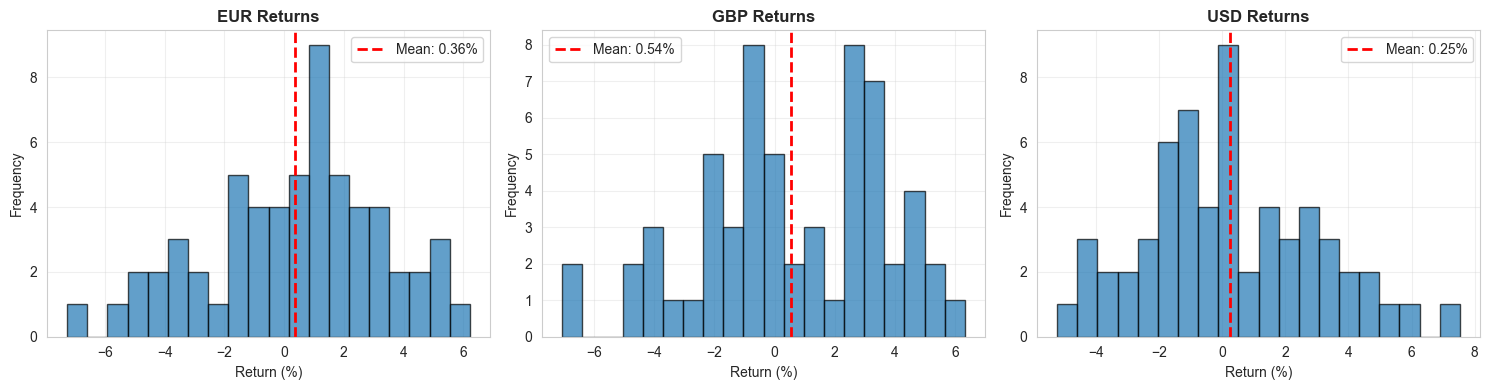


Return Statistics (Monthly):
     Mean (%)  Std Dev (%)  Min (%)  Max (%)
EUR    0.3598       2.9825  -7.2702   6.2205
GBP    0.5364       3.0951  -7.0468   6.3134
USD    0.2544       2.7908  -5.2344   7.5334


In [ ]:
# Plot returns distribution using Portfolio method
fig = portfolio.plot_returns_distribution(returns)
plt.show()

# Return statistics
print("\nReturn Statistics (Monthly):")
stats = pd.DataFrame({
    'Mean (%)': returns.mean() * 100,
    'Std Dev (%)': returns.std() * 100,
    'Min (%)': returns.min() * 100,
    'Max (%)': returns.max() * 100
})
print(stats)

## 4. Simple Simulation (No Cash Flows or Rebalancing)

In [ ]:
# Simulate portfolio NAV history
nav_history = portfolio.simulate_history(returns)

print(f"Simulated {len(nav_history)} periods")
print("\nLast 5 periods:")
nav_history.head()

Simulated 60 periods

Last 5 periods:


,EUR,GBP,USD,Total
Date,,,,
2020-01-31,294511.9061,99018.5031,600039.8101,993570.2192
2020-02-29,282350.1907,94507.8972,577107.9484,953966.0362
2020-03-31,274294.8071,88374.0961,558370.4734,921039.3766
2020-04-30,271263.4753,87818.0808,547489.9650,906571.5211
2020-05-31,269971.5576,90368.1524,523377.3308,883717.0408


In [ ]:
# Portfolio summary
summary = portfolio.summary()
print("\nPORTFOLIO SUMMARY")
print("=" * 80)
print(summary)
print("\n" + "=" * 80)
print(f"Total Return: {portfolio.total_return()*100:.2f}%")
print(f"Annualized Return: {portfolio.annualized_return()*100:.2f}%")


PORTFOLIO SUMMARY
       Initial Weight (%)  Final Weight (%)  Initial NAV    Final NAV  \
EUR               30.0000           30.7306  300000.0000  362494.6446   
GBP               10.0000           11.3614  100000.0000  134017.3594   
USD               60.0000           57.9081  600000.0000  683077.8635   
Total            100.0000          100.0000 1000000.0000 1179589.8674   

       Return (%)  
EUR       20.8315  
GBP       34.0174  
USD       13.8463  
Total     17.9590  

Total Return: 17.96%
Annualized Return: 3.36%


### 4.1 Visualize NAV Growth

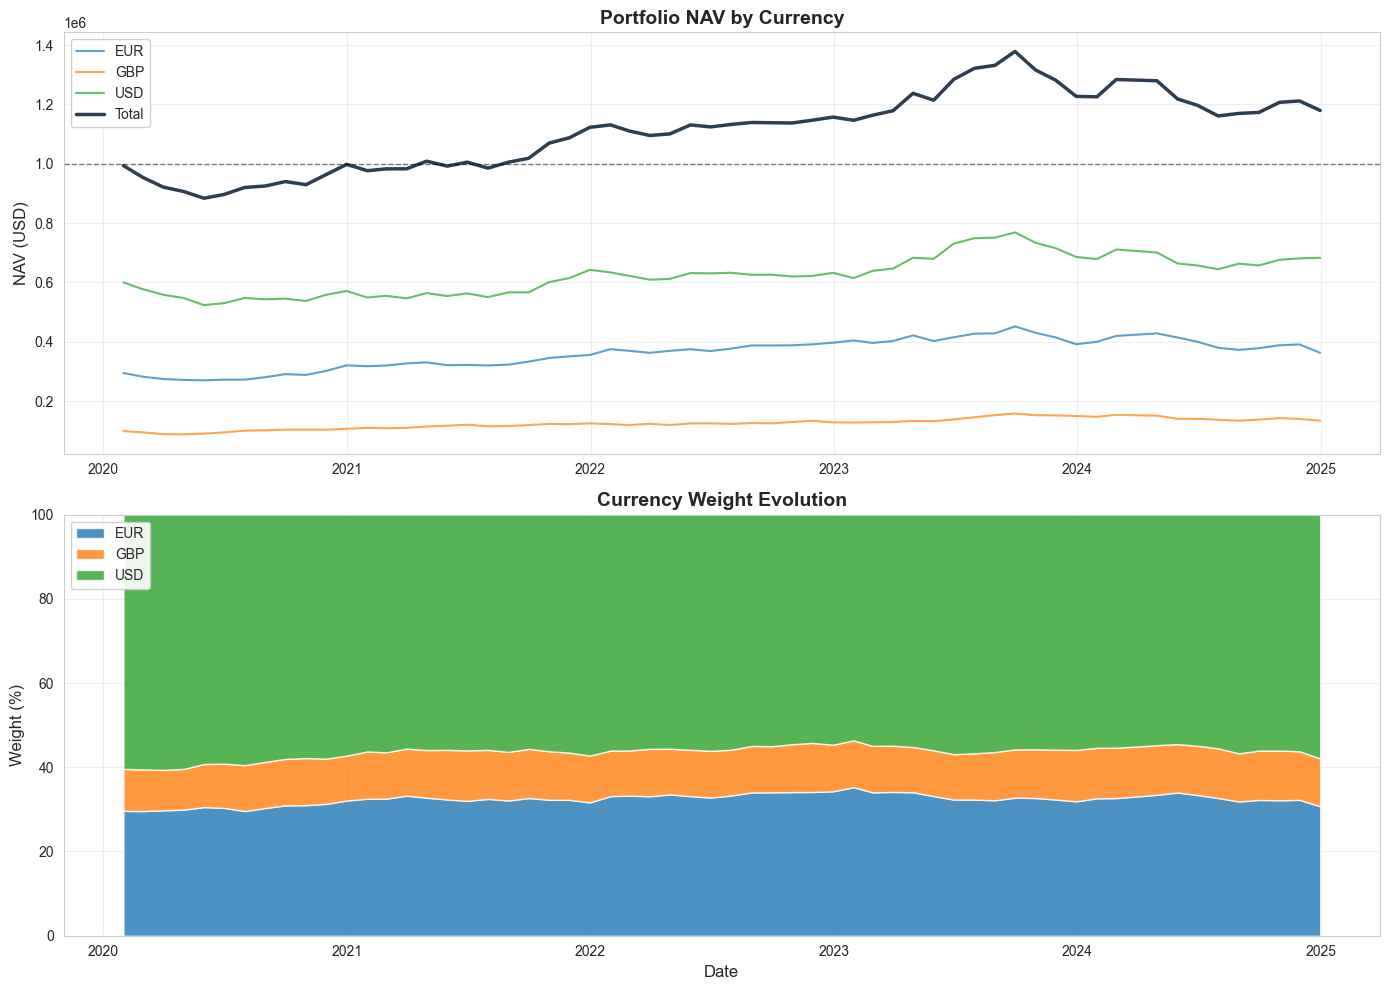

In [ ]:
# Plot NAV and weight evolution using Portfolio method
fig = portfolio.plot_nav_and_weights()
plt.show()

## 5. Portfolio with Cash Flows

Add contributions and withdrawals to the portfolio.

In [ ]:
# Create new portfolio with cash flows
portfolio_cf = Portfolio(
    base_currency='USD',
    init_date=datetime(2020, 1, 1),
    initial_nav=1_000_000,
    weights={'USD': 0.60, 'EUR': 0.30, 'GBP': 0.10},
    periodic_freq='M'
)

# Add cash flows
# Quarterly contributions of $50,000
for year in range(2020, 2025):
    for month in [3, 6, 9, 12]:
        if year == 2024 and month > 12:
            break
        cf_date = datetime(year, month, 1)
        if cf_date <= datetime(2024, 12, 31):
            portfolio_cf.add_cash_flow(CashFlow(
                date=cf_date,
                amount=50_000,
                flow_type='contribution'
            ))

# Add one withdrawal
portfolio_cf.add_cash_flow(CashFlow(
    date=datetime(2023, 1, 1),
    amount=-200_000,
    flow_type='withdrawal'
))

print(f"Portfolio with {len(portfolio_cf.cash_flows)} cash flows")
print("\nCash Flow Schedule:")
cf_df = pd.DataFrame([
    {'Date': cf.date, 'Amount': cf.amount, 'Type': cf.flow_type}
    for cf in portfolio_cf.cash_flows
])
print(cf_df.to_string(index=False))


Portfolio initialized: USD-denominated
IMPORTANT: All currency exposures are valued in USD
  - Each currency's NAV represents USD value of those assets
  - Returns must be in USD terms (FX effects embedded)
  - Example: EUR weight of 30% = $300,000 worth of EUR assets

Portfolio with 21 cash flows

Cash Flow Schedule:
      Date  Amount         Type
2020-03-01   50000 contribution
2020-06-01   50000 contribution
2020-09-01   50000 contribution
2020-12-01   50000 contribution
2021-03-01   50000 contribution
2021-06-01   50000 contribution
2021-09-01   50000 contribution
2021-12-01   50000 contribution
2022-03-01   50000 contribution
2022-06-01   50000 contribution
2022-09-01   50000 contribution
2022-12-01   50000 contribution
2023-01-01 -200000   withdrawal
2023-03-01   50000 contribution
2023-06-01   50000 contribution
2023-09-01   50000 contribution
2023-12-01   50000 contribution
2024-03-01   50000 contribution
2024-06-01   50000 contribution
2024-09-01   50000 contribution
2024-12

In [ ]:
# Simulate with cash flows
nav_history_cf = portfolio_cf.simulate_history(returns)

# Summary
summary_cf = portfolio_cf.summary()
print("\nPORTFOLIO SUMMARY (With Cash Flows)")
print("=" * 80)
print(summary_cf)
print("\n" + "=" * 80)
print(f"Total Return: {portfolio_cf.total_return()*100:.2f}%")
print(f"Annualized Return: {portfolio_cf.annualized_return()*100:.2f}%")


PORTFOLIO SUMMARY (With Cash Flows)
       Initial Weight (%)  Final Weight (%)  Initial NAV    Final NAV  \
EUR               30.0000           30.7306  300000.0000  629382.8890   
GBP               10.0000           11.3614  100000.0000  232688.2178   
USD               60.0000           57.9081  600000.0000 1185996.8845   
Total            100.0000          100.0000 1000000.0000 2048067.9913   

       Return (%)  
EUR      109.7943  
GBP      132.6882  
USD       97.6661  
Total    104.8068  

Total Return: 104.81%
Annualized Return: 15.42%


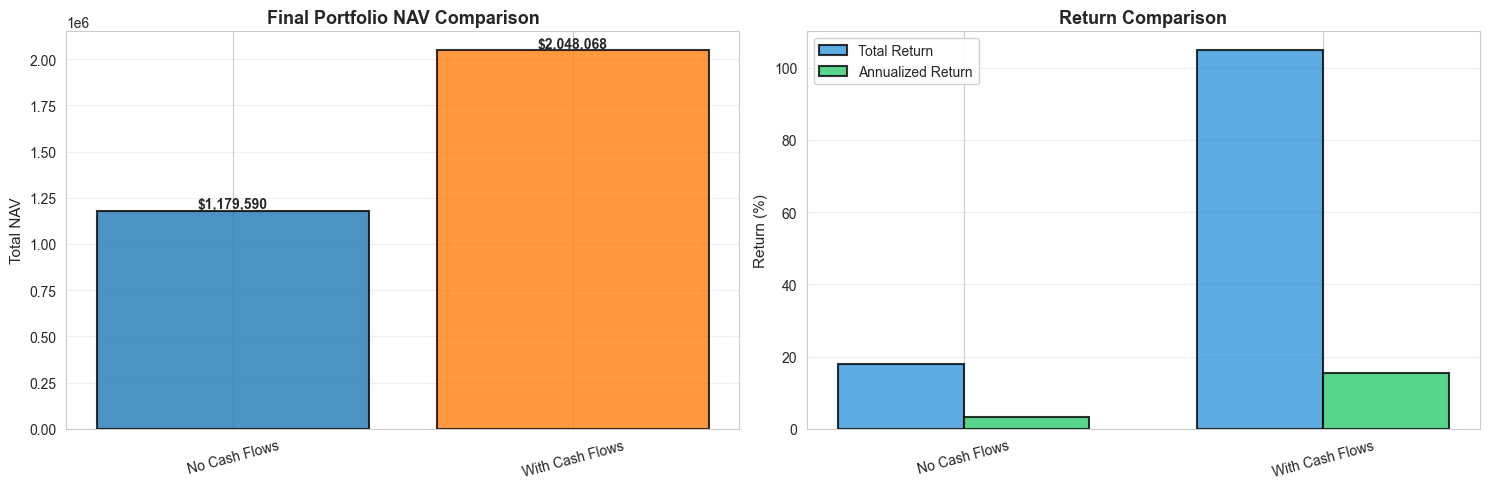

The cash flow date alignment method applies conservativeness thus it may show misalignment with the NAV curve


In [ ]:
# Compare portfolios with and without cash flows using plot_scenario_comparison
comparison_scenarios = {
    'No Cash Flows': portfolio,
    'With Cash Flows': portfolio_cf
}

fig = Portfolio.plot_scenario_comparison(comparison_scenarios)
plt.show()

print('The cash flow date alignment method applies conservativeness thus it may show misalignment with the NAV curve')

## 6. Portfolio with Rebalancing

Add periodic rebalancing to maintain target weights.

In [ ]:
# Create portfolio with rebalancing
portfolio_rebal = Portfolio(
    base_currency='USD',
    init_date=datetime(2020, 1, 1),
    initial_nav=1_000_000,
    weights={'USD': 0.60, 'EUR': 0.30, 'GBP': 0.10},
    periodic_freq='M'
)

# Add annual rebalancing events
# IMPORTANT: Use end-of-month dates to match simulation dates (periodic_freq='M')
rebalance_dates = [
    (datetime(2020, 12, 31), {'USD': 0.55, 'EUR': 0.35, 'GBP': 0.10}),  # End of 2020
    (datetime(2021, 12, 31), {'USD': 0.50, 'EUR': 0.30, 'GBP': 0.20}),  # End of 2021
    (datetime(2022, 12, 31), {'USD': 0.60, 'EUR': 0.25, 'GBP': 0.15}),  # End of 2022
    (datetime(2023, 12, 31), {'USD': 0.55, 'EUR': 0.30, 'GBP': 0.15}),  # End of 2023
]

for date, weights in rebalance_dates:
    portfolio_rebal.add_rebalance(date, weights)

print(f"Portfolio with {len(portfolio_rebal.rebalance_events)} rebalancing events")
print("\nRebalancing Schedule:")
for event in portfolio_rebal.rebalance_events:
    print(f"{event.date.strftime('%Y-%m-%d')}: {event.target_weights}")


Portfolio initialized: USD-denominated
IMPORTANT: All currency exposures are valued in USD
  - Each currency's NAV represents USD value of those assets
  - Returns must be in USD terms (FX effects embedded)
  - Example: EUR weight of 30% = $300,000 worth of EUR assets

Portfolio with 4 rebalancing events

Rebalancing Schedule:
2020-12-31: {'USD': 0.55, 'EUR': 0.35, 'GBP': 0.1}
2021-12-31: {'USD': 0.5, 'EUR': 0.3, 'GBP': 0.2}
2022-12-31: {'USD': 0.6, 'EUR': 0.25, 'GBP': 0.15}
2023-12-31: {'USD': 0.55, 'EUR': 0.3, 'GBP': 0.15}


In [ ]:
# Simulate with rebalancing
nav_history_rebal = portfolio_rebal.simulate_history(returns)

# Summary
summary_rebal = portfolio_rebal.summary()
print("\nPORTFOLIO SUMMARY (With Rebalancing)")
print("=" * 80)
print(summary_rebal)
print("\n" + "=" * 80)
print(f"Total Return: {portfolio_rebal.total_return()*100:.2f}%")
print(f"Annualized Return: {portfolio_rebal.annualized_return()*100:.2f}%")


PORTFOLIO SUMMARY (With Rebalancing)
       Initial Weight (%)  Final Weight (%)  Initial NAV    Final NAV  \
EUR               30.0000           28.9362  300000.0000  345038.3253   
GBP               10.0000           13.9864  100000.0000  166775.3389   
USD               60.0000           57.0774  600000.0000  680598.2816   
Total            100.0000          100.0000 1000000.0000 1192411.9458   

       Return (%)  
EUR       15.0128  
GBP       66.7753  
USD       13.4330  
Total     19.2412  

Total Return: 19.24%
Annualized Return: 3.58%


Weight Evolution WITHOUT Rebalancing:


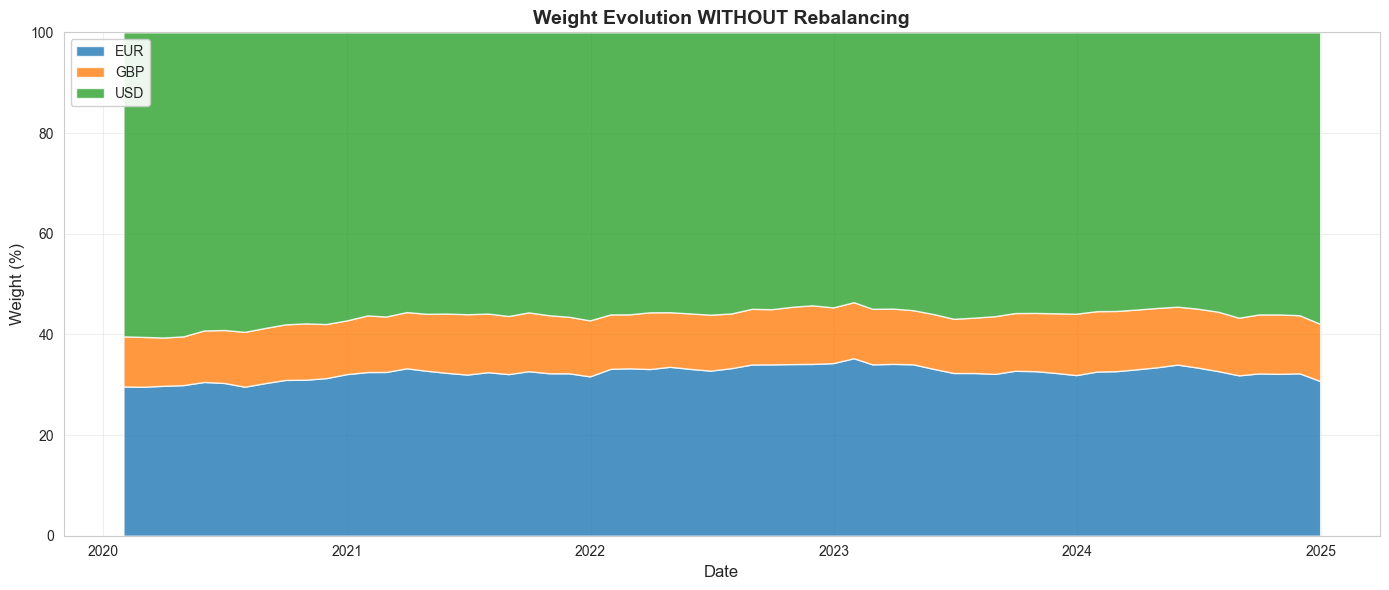


Weight Evolution WITH Rebalancing:


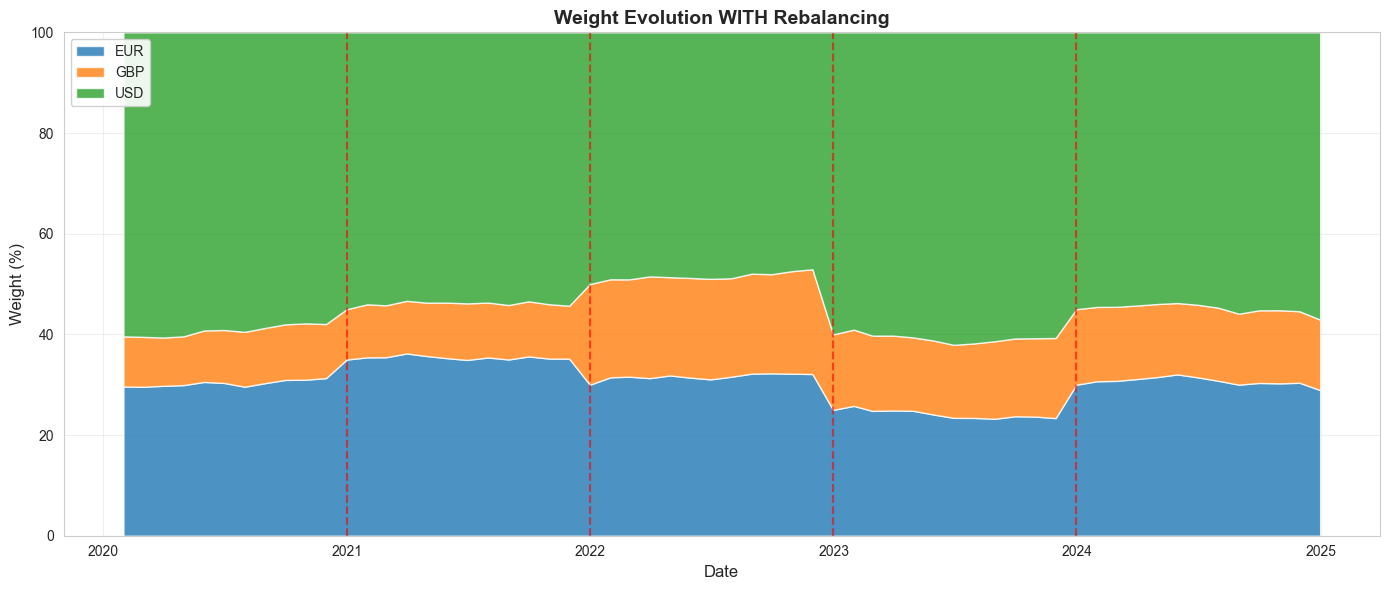

In [ ]:
# Compare weight evolution with and without rebalancing using Portfolio methods
print("Weight Evolution WITHOUT Rebalancing:")
fig1 = portfolio.plot_weight_evolution(
    title='Weight Evolution WITHOUT Rebalancing'
)
plt.show()

print("\nWeight Evolution WITH Rebalancing:")
fig2 = portfolio_rebal.plot_weight_evolution(
    title='Weight Evolution WITH Rebalancing'
)
plt.show()

## 7. Complex Scenario: Cash Flows + Rebalancing + Dynamic Currency

Combine all features: cash flows, rebalancing, and adding a new currency mid-period.

**New Feature (v2.5.1)**: `add_rebalance()` now automatically adds new currencies when they appear in `target_weights`. You don't need to manually add currencies before rebalancing - just include them in your rebalance target weights!

In [ ]:
# Create comprehensive portfolio
# Include JPY in initial weights (even though it starts at 0%)
portfolio_complex = Portfolio(
    base_currency='USD',
    init_date=datetime(2020, 1, 1),
    initial_nav=1_000_000,
    weights={'USD': 0.60, 'EUR': 0.30, 'GBP': 0.10, 'JPY': 0.00},  # JPY starts at 0%
    periodic_freq='M'
)

# Generate returns for all 4 currencies
# Currencies are sorted alphabetically: ['EUR', 'GBP', 'JPY', 'USD']
currencies_complex = ['EUR', 'GBP', 'JPY', 'USD']

returns_complex = portfolio_complex.generate_random_returns(
    currencies=currencies_complex,
    n_periods=60,
    mean_returns=[0.006, 0.0055, 0.004, 0.005], 
    volatilities=[0.035, 0.04, 0.038, 0.03],     
    correlation_matrix=np.array([
        [1.0, 0.65, 0.55, 0.7],  
        [0.65, 1.0, 0.6, 0.6],   
        [0.55, 0.6, 1.0, 0.5],   
        [0.7, 0.6, 0.5, 1.0]     
    ]),
    seed=42
)

# Add quarterly contributions
for year in range(2020, 2025):
    for month in [3, 6, 9, 12]:
        cf_date = datetime(year, month, 1)
        if cf_date <= returns_complex.index[-1]:
            portfolio_complex.add_cash_flow(CashFlow(
                date=cf_date,
                amount=50_000,
                flow_type='contribution'
            ))

# Add rebalancing events (including JPY allocation starting 2022)
# IMPORTANT: Use end-of-month dates to match the simulation dates (periodic_freq='M')
# Note: JPY will be automatically added to portfolio when first referenced in rebalancing
portfolio_complex.add_rebalance(
    datetime(2020, 12, 31),  # End of 2020
    {'USD': 0.55, 'EUR': 0.35, 'GBP': 0.10, 'JPY': 0.00}
)
portfolio_complex.add_rebalance(
    datetime(2021, 12, 31),  # End of 2021
    {'USD': 0.50, 'EUR': 0.25, 'GBP': 0.15, 'JPY': 0.10}  # Allocate to JPY
)
portfolio_complex.add_rebalance(
    datetime(2022, 12, 31),  # End of 2022
    {'USD': 0.45, 'EUR': 0.30, 'GBP': 0.10, 'JPY': 0.15}
)
portfolio_complex.add_rebalance(
    datetime(2023, 12, 31),  # End of 2023
    {'USD': 0.50, 'EUR': 0.35, 'GBP': 0.15, 'JPY': 0.00}  # Remove JPY allocation
)

print(portfolio_complex)
print(f"\nCash flows: {len(portfolio_complex.cash_flows)}")
print(f"Rebalances: {len(portfolio_complex.rebalance_events)}")


Portfolio initialized: USD-denominated
IMPORTANT: All currency exposures are valued in USD
  - Each currency's NAV represents USD value of those assets
  - Returns must be in USD terms (FX effects embedded)
  - Example: EUR weight of 30% = $300,000 worth of EUR assets

Portfolio(base_currency='USD', init_date='2020-01-01', initial_nav=1,000,000.00, currencies=[EUR, GBP, JPY, USD], cash_flows=20, rebalances=4)

Cash flows: 20
Rebalances: 4


In [ ]:
# Simulate complex portfolio
nav_history_complex = portfolio_complex.simulate_history(returns_complex)

print("\nFinal NAV by Currency:")
print(portfolio_complex.current_nav)

print("\nFinal Weights:")
print(portfolio_complex.current_weights)

# Export NAV history to CSV
output_path = Path.cwd().parent / 'data' / 'raw' / 'nav_history.csv'
output_path.parent.mkdir(parents=True, exist_ok=True)
nav_history_complex.to_csv(output_path) 
print(f"\n✓ NAV history exported to: {output_path}")



Final NAV by Currency:
{'EUR': 1024692.377527765, 'GBP': 388514.99356790195, 'JPY': 0.0, 'USD': 1367285.0905076158, 'Total': 2780492.461603283}

Final Weights:
{'EUR': 0.3685290975171026, 'GBP': 0.1397288426180005, 'JPY': 0.0, 'USD': 0.4917420598648968}

✓ NAV history exported to: c:\Users\KOU00\fx_hedging_linear\data\raw\nav_history.csv


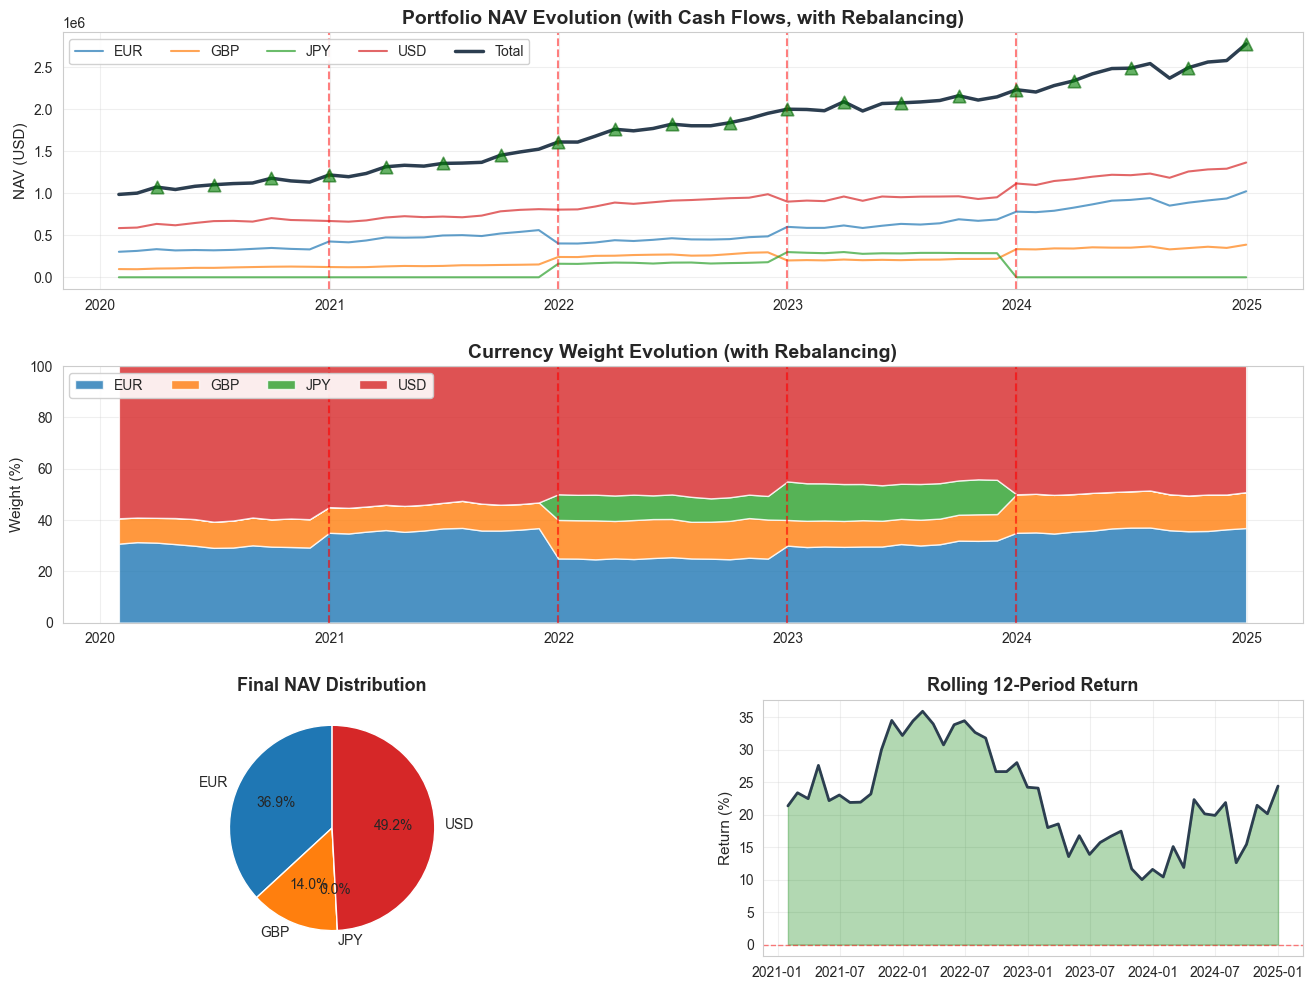

In [ ]:
# Comprehensive visualization using Portfolio method
fig = portfolio_complex.plot_comprehensive_analysis()
plt.show()

## 8. Scenario Comparison

Compare all portfolio scenarios side by side, although this is not a fair comparison across the scenarios.

In [ ]:
# Create comparison DataFrame
scenarios = {
    'Simple': portfolio,
    'With Cash Flows': portfolio_cf,
    'With Rebalancing': portfolio_rebal,
    'Complex': portfolio_complex
}

comparison = pd.DataFrame({
    'Initial NAV': [p.initial_nav for p in scenarios.values()],
    'Final NAV': [p.nav_history['Total'].iloc[-1] for p in scenarios.values()],
    'Total Return (%)': [p.total_return() * 100 for p in scenarios.values()],
    'Annualized Return (%)': [p.annualized_return() * 100 for p in scenarios.values()],
    'Cash Flows': [len(p.cash_flows) for p in scenarios.values()],
    'Rebalances': [len(p.rebalance_events) for p in scenarios.values()]
}, index=scenarios.keys())

print("\nSCENARIO COMPARISON")
print("=" * 100)
print(comparison)
print("=" * 100)


SCENARIO COMPARISON
                  Initial NAV    Final NAV  Total Return (%)  \
Simple                1000000 1179589.8674           17.9590   
With Cash Flows       1000000 2048067.9913          104.8068   
With Rebalancing      1000000 1192411.9458           19.2412   
Complex               1000000 2780492.4616          178.0492   

                  Annualized Return (%)  Cash Flows  Rebalances  
Simple                           3.3585           0           0  
With Cash Flows                 15.4168          21           0  
With Rebalancing                 3.5822           0           4  
Complex                         22.6943          20           4  


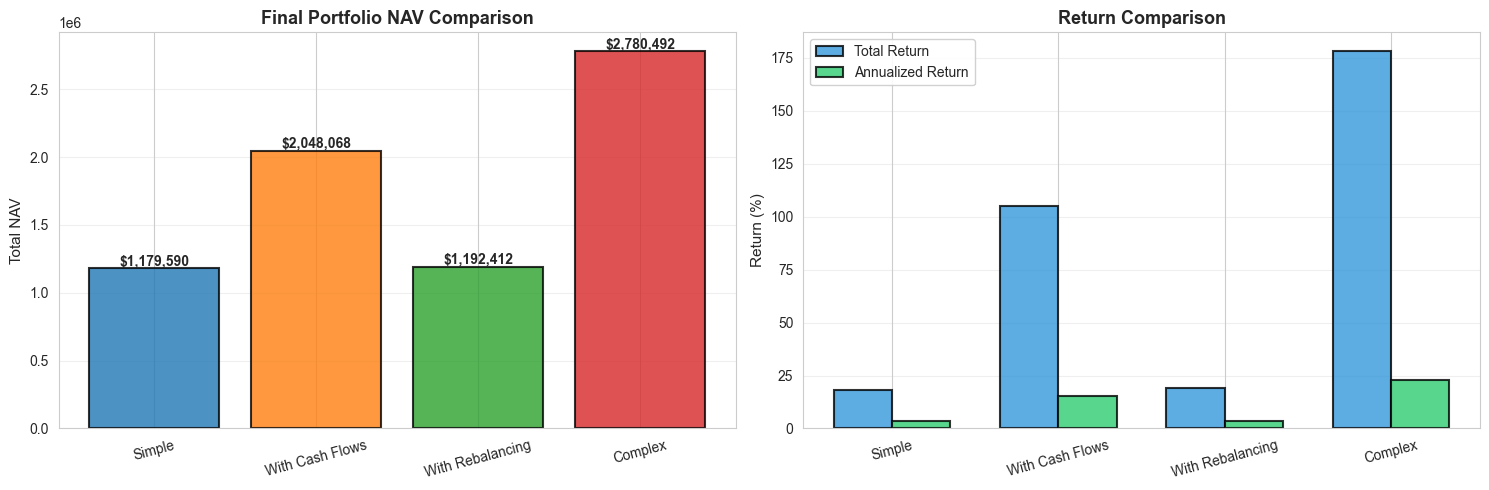

In [ ]:
# Plot scenario comparison using Portfolio static method
fig = Portfolio.plot_scenario_comparison(scenarios)
plt.show()

## 10. Key Takeaways

This notebook demonstrated:

1. **Basic Portfolio Setup**: Multi-currency portfolio with initial weights
2. **Random Return Generation**: Synthetic returns for testing/simulation
3. **Cash Flow Management**: Adding contributions and withdrawals
4. **Rebalancing**: Periodic adjustment to target weights
5. **Dynamic Currency Addition**: Adding new currencies mid-period
6. **Comprehensive Analysis**: NAV tracking, returns, and visualizations
7. **Working with Real NAV Data**: Loading exogenous NAV history from CSV and analyzing performance

### Next Steps

- Integrate with `ForwardCurve` module for FX hedging analysis
- Use `HedgeManager` to analyze hedging strategies
- See `03_hedge_manager_demo.ipynb` for end-to-end hedging workflow

## 9. Working with Real Portfolio NAV History (Exogenous NAV)

Load an existing NAV history from CSV and analyze portfolio performance without simulation.

In [ ]:
# Load NAV history from CSV
nav_csv_path = Path.cwd().parent / 'data' / 'raw' / 'nav_history.csv'

# Read the CSV file
nav_real = pd.read_csv(nav_csv_path, parse_dates=['Date'], index_col='Date')

print(f"Loaded NAV history with {len(nav_real)} periods")
print(f"Date range: {nav_real.index[0].strftime('%Y-%m-%d')} to {nav_real.index[-1].strftime('%Y-%m-%d')}")
print(f"\nCurrencies: {[col for col in nav_real.columns if col != 'Total']}")
print(f"\nFirst 5 periods:")
print(nav_real.head())
print(f"\nLast 5 periods:")
print(nav_real.tail())

Loaded NAV history with 60 periods
Date range: 2020-01-31 to 2024-12-31

Currencies: ['EUR', 'GBP', 'JPY', 'USD']

First 5 periods:
                   EUR         GBP    JPY         USD        Total
Date                                                              
2020-01-31 303930.4984  97525.5367 0.0000 586001.1018  987457.1369
2020-02-29 314333.3284  95941.4082 0.0000 592334.2784 1002609.0150
2020-03-31 335000.1564 103890.5743 0.0000 636030.3834 1074921.1141
2020-04-30 319990.0739 106245.4766 0.0000 619765.5083 1046001.0587
2020-05-31 324772.9938 112549.7011 0.0000 646800.6652 1084123.3601

Last 5 periods:
                    EUR         GBP    JPY          USD        Total
Date                                                                
2024-08-31  853895.7365 332568.4438 0.0000 1185946.3965 2372410.5768
2024-09-30  889034.2405 347755.6189 0.0000 1260608.4130 2497398.2725
2024-10-31  915827.7256 363893.7250 0.0000 1285302.2350 2565023.6856
2024-11-30  938965.4929 350114.2798 0

### 9.1 Using Portfolio.from_nav_history() Constructor

Create a Portfolio object directly from NAV history - no simulation needed!


Portfolio initialized: USD-denominated
IMPORTANT: All currency exposures are valued in USD
  - Each currency's NAV represents USD value of those assets
  - Returns must be in USD terms (FX effects embedded)
  - Example: EUR weight of 30% = $303,930 worth of EUR assets



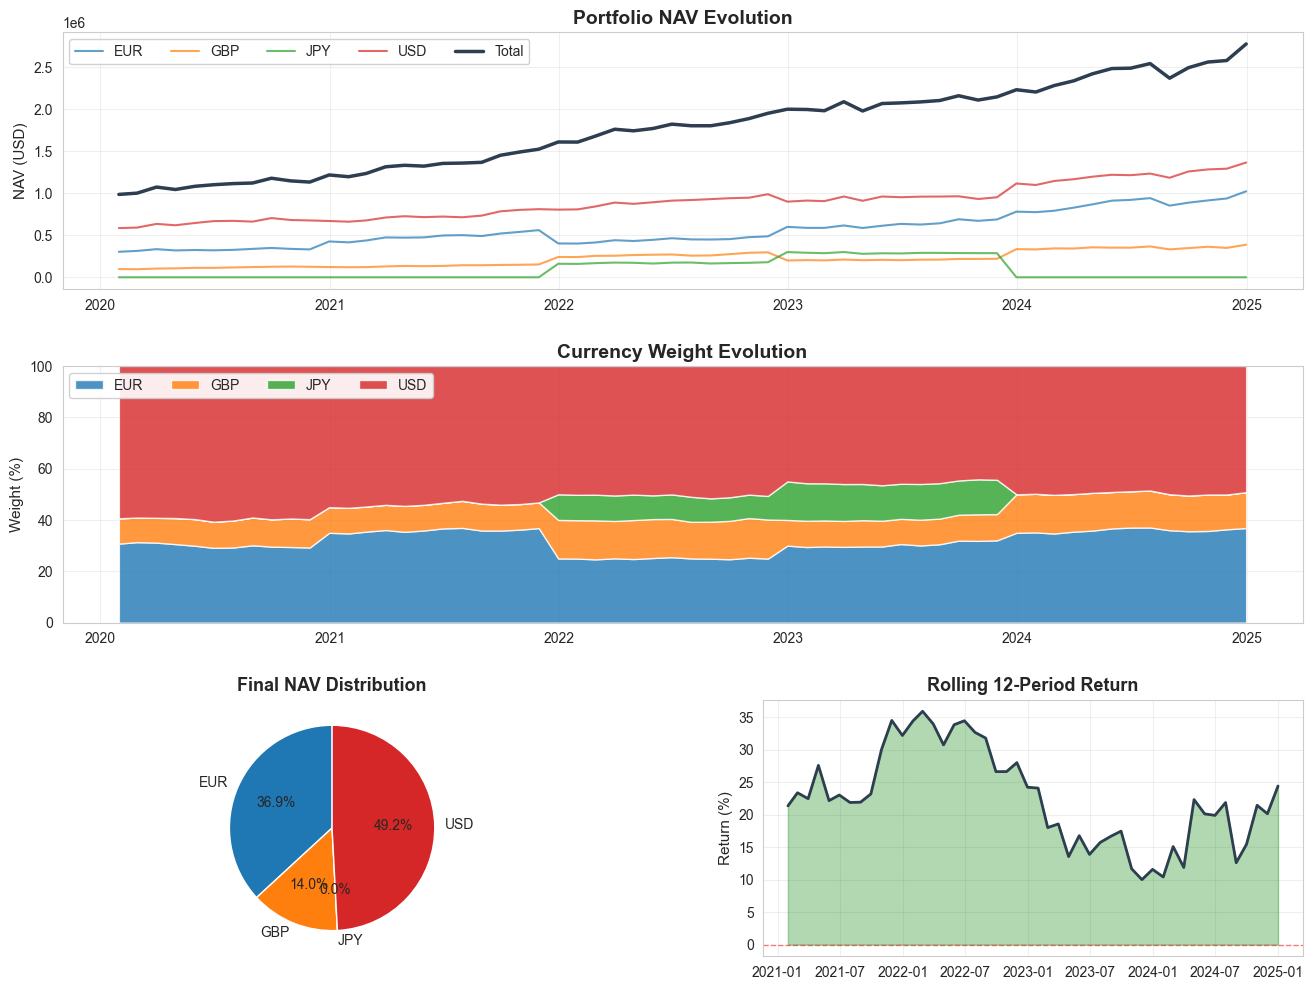


REAL PORTFOLIO PERFORMANCE
Initial NAV: $987,457.14
Final NAV: $2,780,492.46
Total Return: 181.58%
Annualized Return: 23.00%
Time Period: 59 months


In [ ]:
# Visualize real NAV history using Portfolio method
# First, create a Portfolio from the NAV history to access visualization methods
portfolio_real = Portfolio.from_nav_history(nav_real, base_currency='USD')

# Use the comprehensive analysis method
fig = portfolio_real.plot_comprehensive_analysis(mark_cash_flows=False, mark_rebalances=False)
plt.show()

# Additional statistics
print("\nREAL PORTFOLIO PERFORMANCE")
print("=" * 80)
print(f"Initial NAV: ${portfolio_real.initial_nav:,.2f}")
print(f"Final NAV: ${portfolio_real.nav_history['Total'].iloc[-1]:,.2f}")
print(f"Total Return: {portfolio_real.total_return()*100:.2f}%")
print(f"Annualized Return: {portfolio_real.annualized_return()*100:.2f}%")
print(f"Time Period: {len(portfolio_real.nav_history) - 1} months")
print("=" * 80)

In [ ]:
# Create Portfolio directly from NAV history DataFrame
# All parameters are automatically inferred!
portfolio_from_nav = Portfolio.from_nav_history(
    nav_df=nav_real,
    base_currency='USD'
    # periodic_freq is auto-inferred from date spacing (Monthly in this case)
    # init_date, initial_nav, and weights are extracted from first row
)

print("Portfolio created from NAV history:")
print(portfolio_from_nav)
print(f"\nCurrencies: {portfolio_from_nav.currencies}")
print(f"Initial weights (inferred): {portfolio_from_nav.initial_weights}")
print(f"Periodic frequency (inferred): {portfolio_from_nav.periodic_freq}")

# NAV history is already populated - no simulation needed!
print(f"\nNAV history already loaded: {len(portfolio_from_nav.nav_history)} periods")

# Use all Portfolio methods immediately
print("\n" + "=" * 80)
print("PORTFOLIO SUMMARY (from NAV history)")
print("=" * 80)
print(portfolio_from_nav.summary())
print("\n" + "=" * 80)
print(f"Total Return: {portfolio_from_nav.total_return()*100:.2f}%")
print(f"Annualized Return: {portfolio_from_nav.annualized_return()*100:.2f}%")


Portfolio initialized: USD-denominated
IMPORTANT: All currency exposures are valued in USD
  - Each currency's NAV represents USD value of those assets
  - Returns must be in USD terms (FX effects embedded)
  - Example: EUR weight of 30% = $303,930 worth of EUR assets

Portfolio created from NAV history:
Portfolio(base_currency='USD', init_date='2020-01-31', initial_nav=987,457.14, currencies=[EUR, GBP, JPY, USD], cash_flows=0, rebalances=0)

Currencies: ['EUR', 'GBP', 'JPY', 'USD']
Initial weights (inferred): {'EUR': np.float64(0.30779107976440917), 'GBP': np.float64(0.09876432414057368), 'JPY': np.float64(0.0), 'USD': np.float64(0.5934445960950173)}
Periodic frequency (inferred): M

NAV history already loaded: 60 periods

PORTFOLIO SUMMARY (from NAV history)
       Initial Weight (%)  Final Weight (%)  Initial NAV    Final NAV  \
EUR               30.7791           36.8529  303930.4984 1024692.3775   
GBP                9.8764           13.9729   97525.5367  388514.9936   
JPY      